# Validation of `RIMEz` against `pyuvsim` reference simulations

Lily Whitler, Steven Murray, and the HERA Validation Team

<h3 id="tocheading">Table of Contents</h3>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Setup and Metadata

### Abstract

We compare point-source visibilities simulated with `RIMEz` to the first set of reference simulations produced by `pyuvsim`.

### Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from pyuvdata import UVData

In [3]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

### Description

In [4]:
print("Last executed: %s"%str(datetime.now()))

Last executed: 2020-06-01 13:29:57.795860


- **Major Step Description:** {Insert standard description of major step}
- **Minor Variation Description:** {Insert standard description of minor step}
- **Pipelines Tested:** {Brief list of explicit pipelines tested in the notebook}
- **Criteria**:
  1. {Explicit Criterion for success 1}
  2. {Explicit Criterion for success 2}
  

### Summary

The results of this validation test, in reference to the outlined criteria, are
1. {Test results for criteria 1}
2. {Test results for criteria 2...}

{Brief notes on anything else interesting that was noted during testing}

### Software

HERA software used in this validation test, with associate git commit hash:

* {``pyuvdata``: `a8f6b6fdd7261`}
* {If you have the Python Markdown extension, you can do this: ``pyuvdata``: ``{pyuvdata.version.git_hash}``
* {``hera_qm``: `f3e32c3cef36cbd`}
* {etc.}

Versions of other software used in this validation test:

* {``numpy``: vx.x.x}
* {etc. (only list imported modules).}

### Utility Functions

In [5]:
def get_xy_en_polarization(pol, x_orientation='e'):
    """
    Get a polarization string in both the X/Y and E/N conventions
    
    Parameters
    ----------
    pol : str
        The polarization for which to determine the X/Y and E/N strings
    x_orientation : str
        Which direction (east or north) corresponds to the x-orientation
    
    Returns
    -------
    xy_pol : str
        The polarization string in the X/Y convention
    en_pol : str
        The polarization string in the E/N convention corresponding to the X/Y string
    """
    pol, x_orientation = pol.lower(), x_orientation.lower()
    assert x_orientation in ['e', 'n'], 'X orientation must be either E or N'
    
    # Sort out the y orientation
    if x_orientation == 'e':
        y_orientation = 'n'
    else:
        y_orientation = 'e'
        
    # Determine the X/Y and E/N polarization strings
    if pol in ['xx', 'yy', 'xy', 'xx']:
        xy_pol = pol
        en_pol = xy_pol.replace('x', x_orientation).replace('y', y_orientation)
    elif pol in ['ee', 'nn', 'en', 'ne']:
        en_pol = pol
        xy_pol = en_pol.replace(x_orientation, 'x').replace(y_orientation, 'y')
    else:
        raise AssertionError('Polarization not recognized')
        
    return xy_pol, en_pol

In [6]:
# omnibus plotting function that got out of hand, I'll split this up later
def plot_comparison(ref_uvd, rimez_uvd, bls, xaxis, ax,
                    pol='ee', component='amp',
                    xlabel='', colors=None):    
    xy_pol, en_pol = get_xy_en_polarization(pol)    
    
    if component == 'real':
        function = np.real
        name = 'Real'
    elif component == 'imag':
        function = np.imag
        name = 'Imag'
    elif component == 'amp':
        function = np.abs
        name = 'Amp'
    elif component == 'phase':
        function = np.angle
        name = 'Phase'
    
    if colors is None:
        colors=['#5296C1', '#2F0F3E']
    
    for i, bl in enumerate(bls):
        ant1, ant2 = ref_uvd.baseline_to_antnums(bl)
        key_ref = (ant1, ant2, xy_pol)
        key_rimez = (ant1, ant2, en_pol)
        
        # Overplot the visibilities in the left column
        ref_data = function(ref_uvd.get_data(key_ref))
        rimez_data = function(rimez_uvd.get_data(key_rimez))
        if 'freq' in xlabel.lower():
            # This just takes the first time
            ref_data, rimez_data = ref_data[0], rimez_data[0]
        ax[i, 0].plot(xaxis, ref_data, c=colors[0], label='reference')
        ax[i, 0].plot(xaxis, rimez_data, c=colors[1], alpha=0.95, label='RIMEz')
        
        # And the differences (function(RIMEZ-ref) and function(RIMEz) - function(ref))
        # in the right column
        diff_first = function(rimez_uvd.get_data(key_rimez) - ref_uvd.get_data(key_ref))
        function_first = (function(rimez_uvd.get_data(key_rimez)) -
                          function(ref_uvd.get_data(key_ref)))
        if 'freq' in xlabel.lower():
            # The first time
            diff_first, function_first = diff_first[0], function_first[0]
        ax[i, 1].axhline(0, c='#6B6B6B', ls=':', lw=1.5)
        ax[i, 1].plot(xaxis, function_first, c='#39B976',
                      label='{}(RIMEz) - {}(reference)'.format(name, name))
        ncols = 1
        if component != 'phase':
            ax[i, 1].plot(xaxis, diff_first, c='#3C4D8A',
                          label='{}(RIMEz - reference)'.format(name))
            ncols = 2
        
        # Labeling things
        ax[i, 0].set_ylabel(name, fontsize=14)          
        ax[i, 1].text(1.03, 0.5, '({}, {})'.format(ant1, ant2), fontsize=14, ha='center',
                      va='center', rotation=270, transform=ax[i, 1].transAxes)
        
    ax[-1, 0].set_xlabel(xlabel, fontsize=14)
    ax[-1, 1].set_xlabel(xlabel, fontsize=14)
    ax[0, 0].legend(loc='center', ncol=2, fontsize=14, frameon=False, bbox_to_anchor=(0.5, 1.25))
    ax[0, 1].legend(loc='center', ncol=ncols, columnspacing=1, handlelength=1.25,
                    fontsize=14, frameon=False, bbox_to_anchor=(0.5, 1.25))

In [7]:
def plot_time_axis(ref_uvd, rimez_uvd, bls, ax,
                   pol='ee', component='amp',
                   colors=['#5296C1', '#2F0F3E'],
                   labels=['reference', 'RIMEz']):
    times = np.unique(ref_uvd.time_array)
    plot_comparison(ref_uvd, rimez_uvd, bls, times, ax=ax,
                    pol=pol, component=component,
                    xlabel='Time  [JD]', colors=colors)
    
def plot_freq_axis(ref_uvd, rimez_uvd, bls, ax,
                   pol='ee', component='amp',
                   fig=None, colors=['#5296C1', '#2F0F3E'],
                   labels=['reference', 'RIMEz']):
    freqs = np.unique(ref_uvd.freq_array) / 1e6  # MHz
    plot_comparison(ref_uvd, rimez_uvd, bls, freqs, ax=ax,
                    pol=pol, component=component,
                    xlabel='Frequency  [MHz]', colors=colors)

### Data

The following paths point to the configuration files used to create the `RIMEz` simulations used in this notebook, but are never read here.

In [8]:
config_base = '/home/lwhitler/src/pyuvsim/reference_simulations/first_generation'
config_dict = {'1.1_uniform': os.path.join(config_base, 'obsparam_ref_1.1_downsampled_mwa.yaml'),
               '1.2_uniform': os.path.join(config_base, 'obsparam_ref_1.2_zenith_1freq_uniform.yaml'),
               '1.2_gauss': os.path.join(config_base, 'obsparam_ref_1.2_zenith_1freq_gauss.yaml'),
               '1.2_airy': os.path.join(config_base, 'obsparam_ref_1.2_zenith_1freq_airy.yaml'),
               '1.2_uvbeam': os.path.join(config_base, 'obsparam_ref_1.2_zenith_1freq_uvbeam.yaml'),
               '1.3_uniform': os.path.join(config_base, 'obsparam_ref_1.3_uniform.yaml'),
               '1.3_gauss': os.path.join(config_base, 'obsparam_ref_1.3_gauss.yaml'),
               '1.3_airy': os.path.join(config_base, 'obsparam_ref_1.3_airy.yaml'),
               '1.3_uvbeam': os.path.join(config_base, 'obsparam_ref_1.3_uvbeam.yaml')}

for key in config_dict.keys():
    print('{}: {}'.format(key, config_dict[key]))

1.1_uniform: /home/lwhitler/src/pyuvsim/reference_simulations/first_generation/obsparam_ref_1.1_downsampled_mwa.yaml
1.2_uniform: /home/lwhitler/src/pyuvsim/reference_simulations/first_generation/obsparam_ref_1.2_zenith_1freq_uniform.yaml
1.2_gauss: /home/lwhitler/src/pyuvsim/reference_simulations/first_generation/obsparam_ref_1.2_zenith_1freq_gauss.yaml
1.2_airy: /home/lwhitler/src/pyuvsim/reference_simulations/first_generation/obsparam_ref_1.2_zenith_1freq_airy.yaml
1.2_uvbeam: /home/lwhitler/src/pyuvsim/reference_simulations/first_generation/obsparam_ref_1.2_zenith_1freq_uvbeam.yaml
1.3_uniform: /home/lwhitler/src/pyuvsim/reference_simulations/first_generation/obsparam_ref_1.3_uniform.yaml
1.3_gauss: /home/lwhitler/src/pyuvsim/reference_simulations/first_generation/obsparam_ref_1.3_gauss.yaml
1.3_airy: /home/lwhitler/src/pyuvsim/reference_simulations/first_generation/obsparam_ref_1.3_airy.yaml
1.3_uvbeam: /home/lwhitler/src/pyuvsim/reference_simulations/first_generation/obsparam_ref

The following paths reflect the exact locations of all data used in this test. The `RIMEz` data was created with the script found at `/home/lwhitler/data/validation/rimez/prepare_rimez_data.py`.

In [9]:
# all paths are temporarily on Enterprise until I can move things to Lustre
ref_path = '/home/lwhitler/src/pyuvsim/reference_simulations/latest_ref_data/gen1'
ref_path_dict = {'1.1_uniform': os.path.join(ref_path, 'ref_1.1_uniform.uvh5'),
                 '1.2_uniform': os.path.join(ref_path, 'ref_1.2_zenith_1freq_uniform.uvh5'),
                 '1.2_gauss': os.path.join(ref_path, 'ref_1.2_zenith_1freq_gauss.uvh5'),
                 '1.2_airy': os.path.join(ref_path, 'ref_1.2_zenith_1freq_airy.uvh5'),
                 '1.2_uvbeam': os.path.join(ref_path, 'ref_1.2_zenith_1freq_uvbeam.uvh5'),
                 '1.3_uniform': os.path.join(ref_path, 'ref_1.3_uniform.uvh5'),
                 '1.3_gauss': os.path.join(ref_path, 'ref_1.3_gauss.uvh5'),
                 '1.3_airy': os.path.join(ref_path, 'ref_1.3_airy.uvh5'),
                 '1.3_uvbeam': os.path.join(ref_path, 'ref_1.3_uvbeam.uvh5')}

# there is some trickiness with values of lmax in filenames--this will be addressed later
rimez_path = '/home/lwhitler/data/validation/rimez/rimez_sims'
rimez_path_dict = {'1.1_uniform': os.path.join(rimez_path, 'rimez_1.1_uniform_lmax249.uvh5'),
                   '1.2_uniform': os.path.join(rimez_path, 'rimez_1.2_zenith_1freq_uniform_lmax250.uvh5'),
                   '1.2_gauss': os.path.join(rimez_path, 'rimez_1.2_zenith_1freq_gauss_lmax250.uvh5'),
                   '1.2_airy': os.path.join(rimez_path, 'rimez_1.2_zenith_1freq_airy_lmax250.uvh5'),
                   '1.2_uvbeam': os.path.join(rimez_path, 'rimez_1.2_zenith_1freq_uvbeam_lmax250.uvh5'),
                   '1.3_uniform': os.path.join(rimez_path, 'rimez_1.3_uniform_lmax472.uvh5'),
                   '1.3_gauss': os.path.join(rimez_path, 'rimez_1.3_gauss_lmax472.uvh5'),
                   '1.3_airy': os.path.join(rimez_path, 'rimez_1.3_airy_lmax472.uvh5'),
                   '1.3_uvbeam': os.path.join(rimez_path, 'rimez_1.3_uvbeam_lmax472.uvh5')}

## Reference simulation 1.1 (one time, one frequency)

## Reference simulation 1.2 (long time axis)

In [10]:
uvd_ref_12 = {'uniform': UVData(),
              'gauss': UVData(),
              'airy': UVData(),
              'hera': UVData()}
uvd_ref_12['uniform'].read(ref_path_dict['1.2_uniform'], run_check_acceptability=False)
uvd_ref_12['gauss'].read(ref_path_dict['1.2_gauss'], run_check_acceptability=False)
uvd_ref_12['airy'].read(ref_path_dict['1.2_airy'], run_check_acceptability=False)
uvd_ref_12['hera'].read(ref_path_dict['1.2_uvbeam'], run_check_acceptability=False)

uvd_rimez_12 = {'uniform': UVData(),
                'gauss': UVData(),
                'airy': UVData(),
                'hera': UVData()}
uvd_rimez_12['uniform'].read(rimez_path_dict['1.2_uniform'], run_check_acceptability=False)
uvd_rimez_12['gauss'].read(rimez_path_dict['1.2_gauss'], run_check_acceptability=False)
uvd_rimez_12['airy'].read(rimez_path_dict['1.2_airy'], run_check_acceptability=False)
uvd_rimez_12['hera'].read(rimez_path_dict['1.2_uvbeam'], run_check_acceptability=False)

# conjugate the RIMEz data to the pyuvsim convention (ant2 < ant1)
for beam in uvd_rimez_12.keys():
    uvd_rimez_12[beam].conjugate_bls(convention='ant2<ant1')

bls_12 = np.unique(uvd_rimez_12['uniform'].baseline_array)

# Sort the baselines by length, shortest to longest
antpos, ants = uvd_ref_12['uniform'].get_ENU_antpos()
ant_dict = dict(zip(ants, antpos))
bl_length = []
for bl in bls_12:
    ant1, ant2 = uvd_rimez_12['uniform'].baseline_to_antnums(bl)
    bl_length.append(np.linalg.norm(ant_dict[ant1] - ant_dict[ant2]))
inds = np.array(bl_length).argsort()
bls_12 = bls_12[inds]

Telescope BLLITE is not in known_telescopes.
antenna_diameters is not set. Using known values for HERA.
Telescope RIMEz is not in known_telescopes.


### 1.2/1.3: Array layout

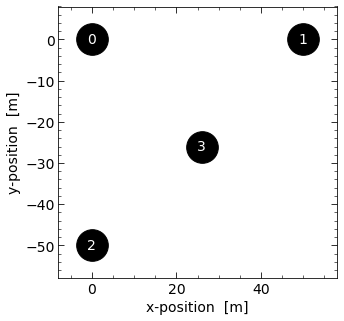

In [11]:
antpos, ants = uvd_ref_12['uniform'].get_ENU_antpos()
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(len(ants)):
    ax.scatter(antpos[i, 0], antpos[i, 1], c='k', marker='o', s=1000)
    ax.text(antpos[i, 0], antpos[i, 1], str(i), color='w',
            ha='center', va='center', fontsize=14)
ax.set_xlabel('x-position  [m]', fontsize=14)
ax.set_ylabel('y-position  [m]', fontsize=14)
ax.set_xlim([-8, 58])
ax.set_ylim([-58, 8]);

**Figure 1** | The array layout for reference simulations 1.2 and 1.3.

### 1.2: Uniform beam

#### Amplitude

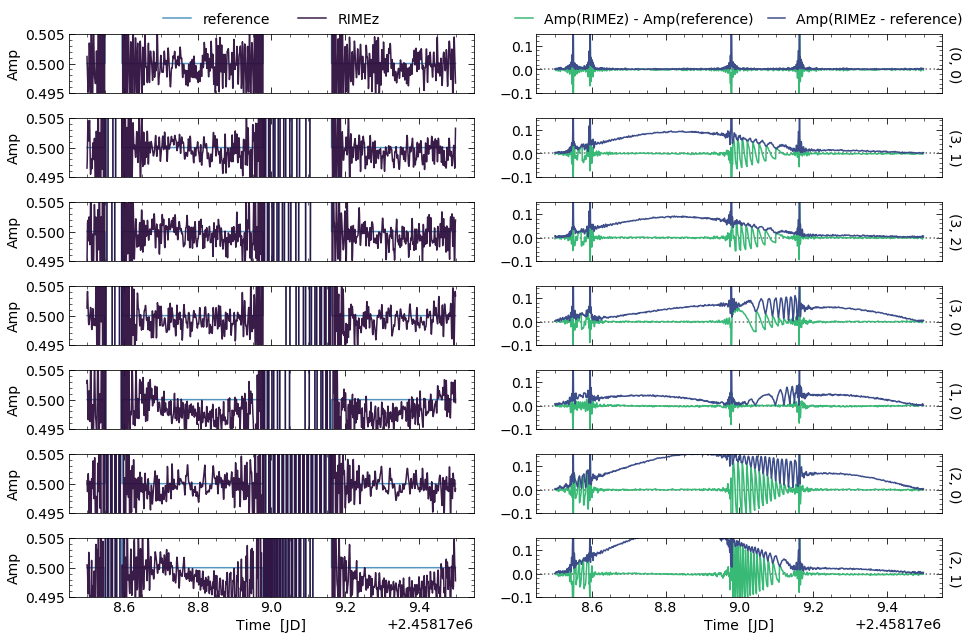

In [12]:
fig, ax = plt.subplots(len(bls_12), 2, sharex='col', figsize=(14, 9))
plot_time_axis(uvd_ref_12['uniform'], uvd_rimez_12['uniform'], bls_12, ax=ax, component='amp')
for axis in ax[:, 0]:
    axis.set_ylim([0.495, 0.505])
for axis in ax[:, 1]:
    axis.set_ylim([-0.1, 0.15])
fig.tight_layout()

#### Phase

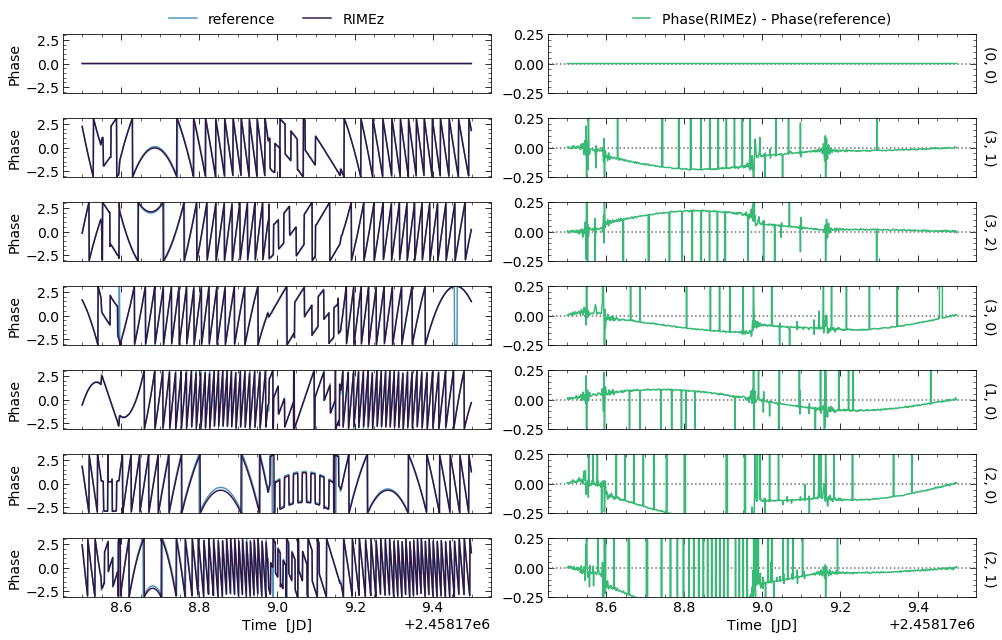

In [13]:
fig, ax = plt.subplots(len(bls_12), 2, sharex='col', figsize=(14, 9))
plot_time_axis(uvd_ref_12['uniform'], uvd_rimez_12['uniform'], bls_12, ax=ax, component='phase')
for axis in ax[:, 0]:
    axis.set_ylim([-np.pi, np.pi])
for axis in ax[:, 1]:
    axis.set_ylim([-0.25, 0.25])
fig.tight_layout()

### 1.2: Gaussian beam

#### Amplitude

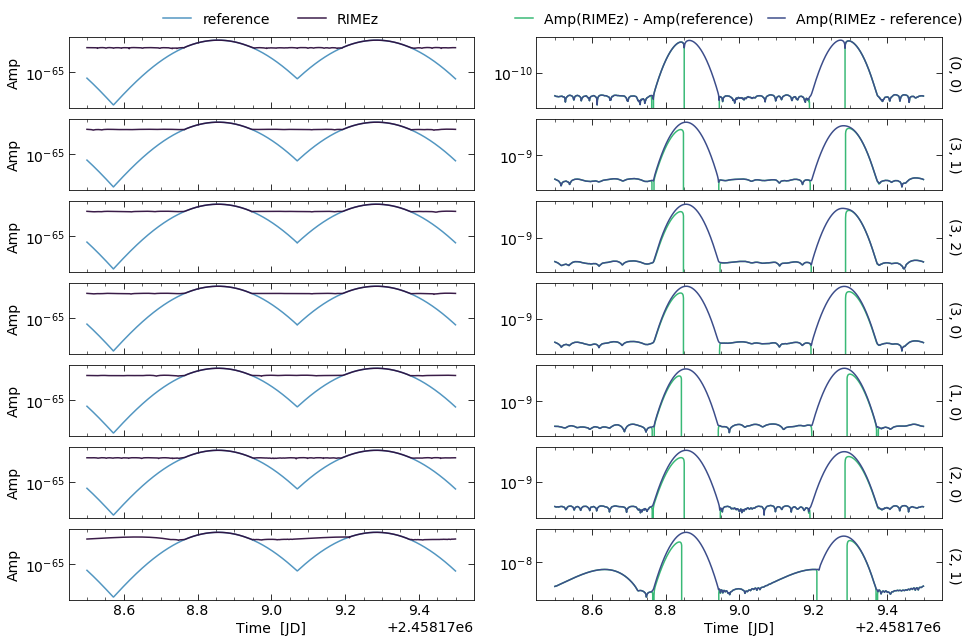

In [14]:
fig, ax = plt.subplots(len(bls_12), 2, sharex='col', figsize=(14, 9))
plot_time_axis(uvd_ref_12['gauss'], uvd_rimez_12['gauss'], bls_12, ax=ax, component='amp')
for axis in ax[:, 0]:
    axis.set_yscale('log')
for axis in ax[:, 1]:
    axis.set_yscale('log')
fig.tight_layout()

#### Phase

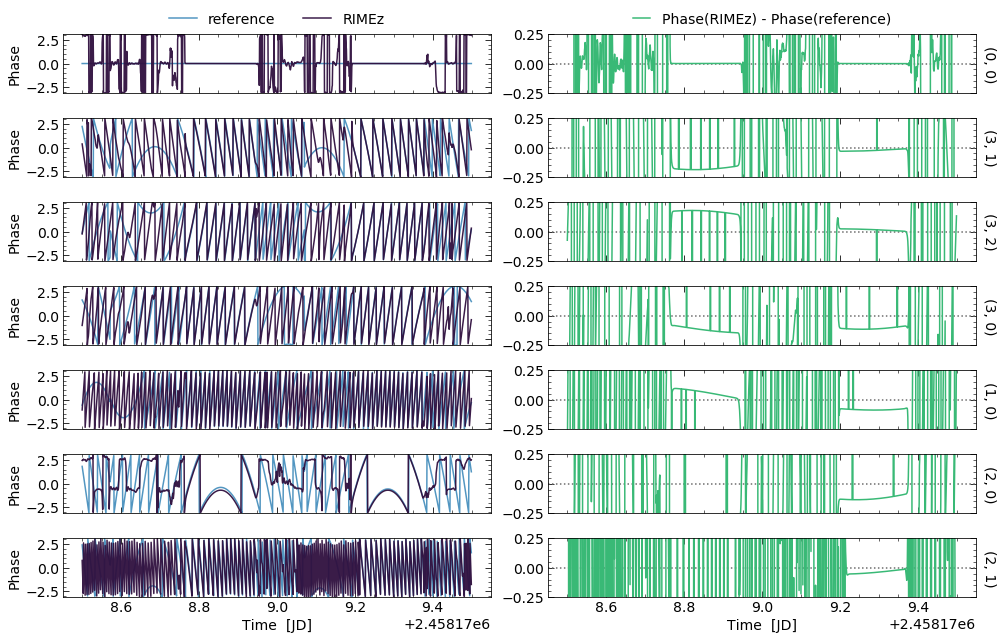

In [15]:
fig, ax = plt.subplots(len(bls_12), 2, sharex='col', figsize=(14, 9))
plot_time_axis(uvd_ref_12['gauss'], uvd_rimez_12['gauss'], bls_12, ax=ax, component='phase')
for axis in ax[:, 0]:
    axis.set_ylim([-np.pi, np.pi])
for axis in ax[:, 1]:
    axis.set_ylim([-0.25, 0.25])
fig.tight_layout()

### 1.2: Airy beam

#### Amplitude

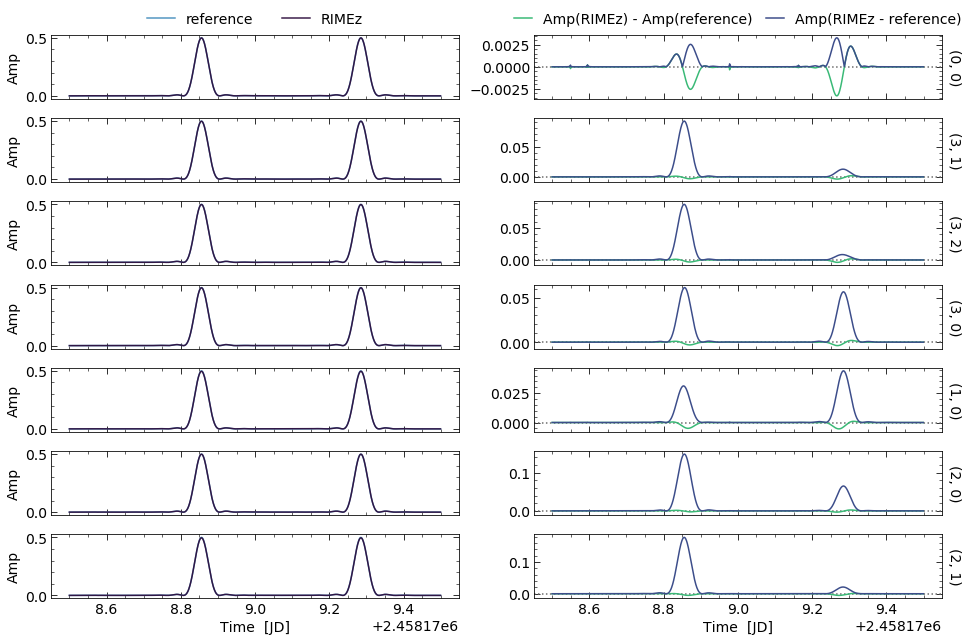

In [16]:
fig, ax = plt.subplots(len(bls_12), 2, sharex='col', figsize=(14, 9))
plot_time_axis(uvd_ref_12['airy'], uvd_rimez_12['airy'], bls_12, ax=ax, component='amp')
fig.tight_layout()

#### Phase

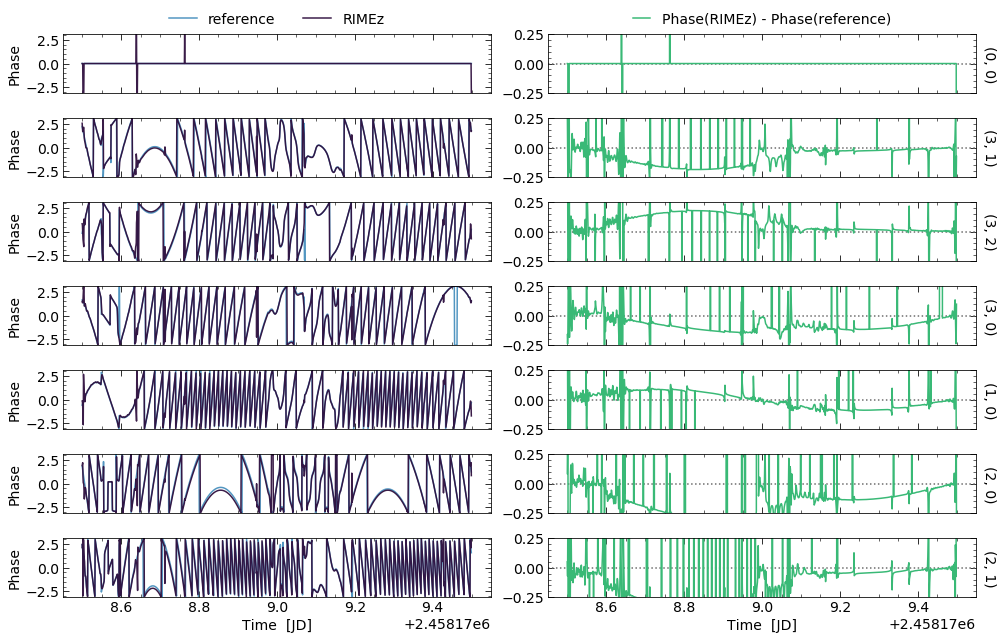

In [17]:
fig, ax = plt.subplots(len(bls_12), 2, sharex='col', figsize=(14, 9))
plot_time_axis(uvd_ref_12['airy'], uvd_rimez_12['airy'], bls_12, ax=ax, component='phase')
for axis in ax[:, 0]:
    axis.set_ylim([-np.pi, np.pi])
for axis in ax[:, 1]:
    axis.set_ylim([-0.25, 0.25])
fig.tight_layout()

### 1.2: HERA beam

#### Amplitude

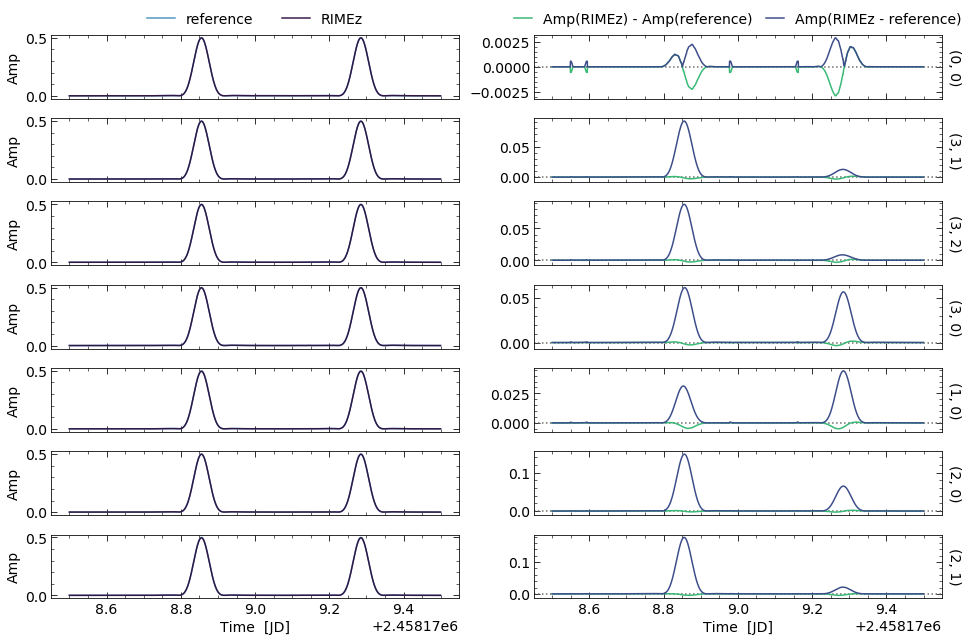

In [18]:
fig, ax = plt.subplots(len(bls_12), 2, sharex='col', figsize=(14, 9))
plot_time_axis(uvd_ref_12['hera'], uvd_rimez_12['hera'], bls_12, ax=ax, component='amp')
fig.tight_layout()

#### Phase

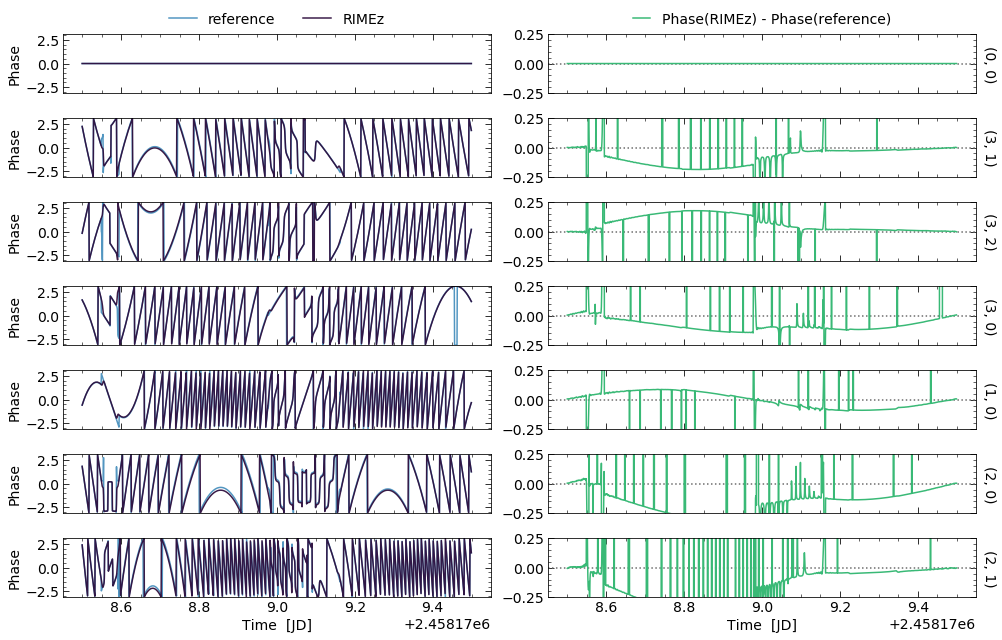

In [19]:
fig, ax = plt.subplots(len(bls_12), 2, sharex='col', figsize=(14, 9))
plot_time_axis(uvd_ref_12['hera'], uvd_rimez_12['hera'], bls_12, ax=ax, component='phase')
for axis in ax[:, 0]:
    axis.set_ylim([-np.pi, np.pi])
for axis in ax[:, 1]:
    axis.set_ylim([-0.25, 0.25])
fig.tight_layout()

## Reference Simulation 1.3 (long frequency axis)

In [20]:
uvd_ref_13 = {'uniform': UVData(),
              'gauss': UVData(),
              'airy': UVData(),
              'hera': UVData()}
uvd_ref_13['uniform'].read(ref_path_dict['1.3_uniform'], run_check_acceptability=False)
uvd_ref_13['gauss'].read(ref_path_dict['1.3_gauss'], run_check_acceptability=False)
# uvd_ref_13['airy'].read(ref_path_dict['1.3_airy'], run_check_acceptability=False)
# uvd_ref_13['hera'].read(ref_path_dict['1.3_uvbeam'], run_check_acceptability=False)

uvd_rimez_13 = {'uniform': UVData(),
                'gauss': UVData(),
                'airy': UVData(),
                'hera': UVData()}
uvd_rimez_13['uniform'].read(rimez_path_dict['1.3_uniform'], run_check_acceptability=False)
uvd_rimez_13['gauss'].read(rimez_path_dict['1.3_gauss'], run_check_acceptability=False)
# uvd_rimez_13['airy'].read(rimez_path_dict['1.3_airy'], run_check_acceptability=False)
# uvd_rimez_13['hera'].read(rimez_path_dict['1.3_uvbeam'], run_check_acceptability=False)

# conjugate the RIMEz data to the pyuvsim convention (ant2 < ant1)
# for beam in uvd_rimez_13.keys():
for beam in ['uniform', 'gauss']:
    uvd_rimez_13[beam].conjugate_bls(convention='ant2<ant1')

bls_13 = np.unique(uvd_rimez_13['uniform'].baseline_array)

# Sort the baselines by length, shortest to longest
antpos, ants = uvd_ref_13['uniform'].get_ENU_antpos()
ant_dict = dict(zip(ants, antpos))
bl_length = []
for bl in bls_13:
    ant1, ant2 = uvd_rimez_13['uniform'].baseline_to_antnums(bl)
    bl_length.append(np.linalg.norm(ant_dict[ant1] - ant_dict[ant2]))
inds = np.array(bl_length).argsort()
bls_13 = bls_13[inds]

Telescope BLLITE is not in known_telescopes.
Telescope RIMEz is not in known_telescopes.


### 1.3: Uniform beam

#### Amplitude

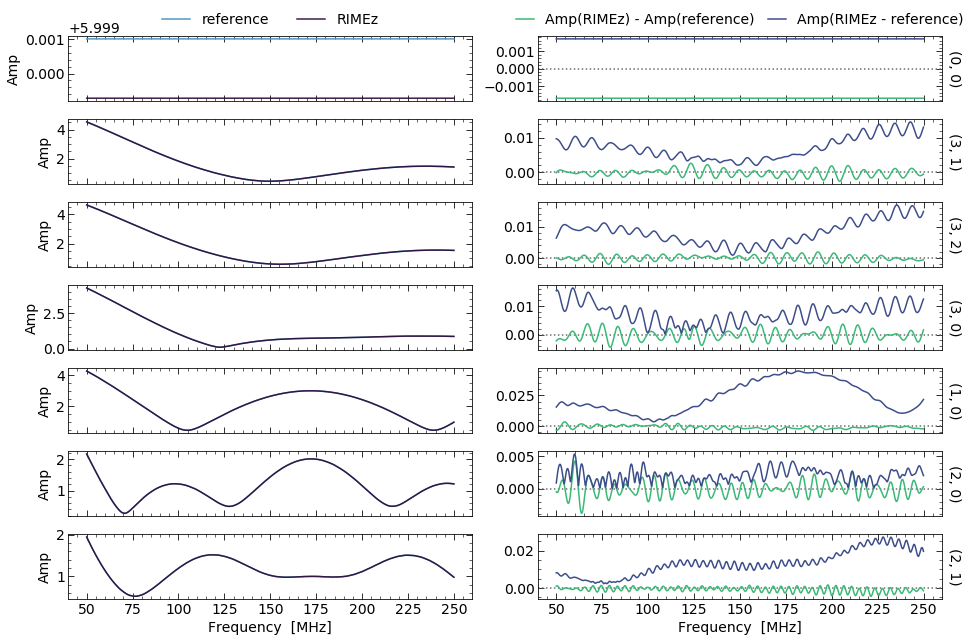

In [21]:
fig, ax = plt.subplots(len(bls_13), 2, sharex='col', figsize=(14, 9))
plot_freq_axis(uvd_ref_13['uniform'], uvd_rimez_13['uniform'], bls_13, ax=ax, component='amp')
fig.tight_layout()

Note: The slow frequency structure in the difference plots reflect the absolute amplitudes of the visiblities

#### Phase

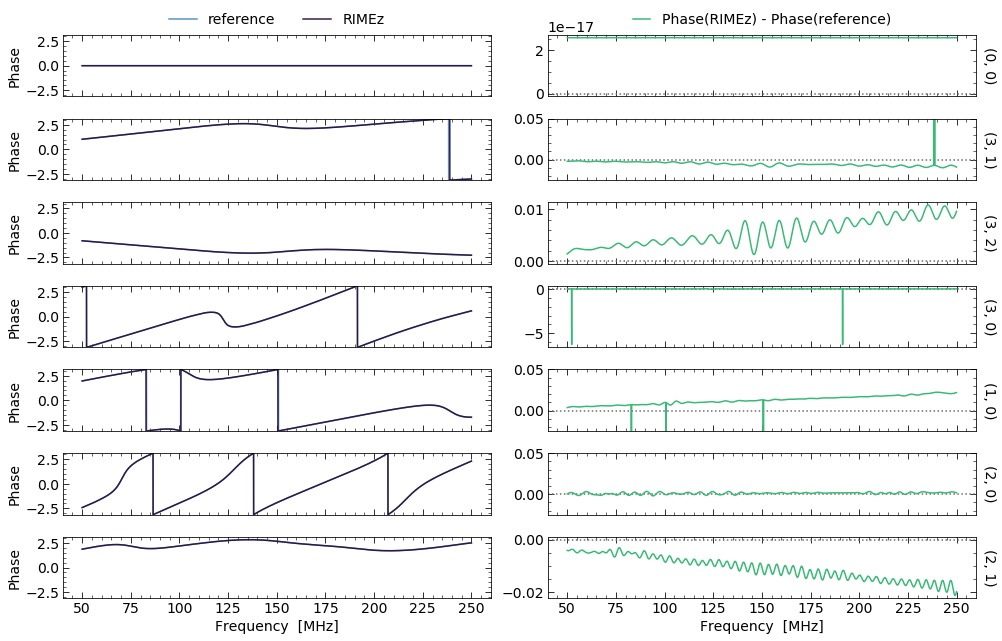

In [22]:
fig, ax = plt.subplots(len(bls_13), 2, sharex='col', figsize=(14, 9))
plot_freq_axis(uvd_ref_13['uniform'], uvd_rimez_13['uniform'], bls_13, ax=ax, component='phase')
for axis in ax[:, 0]:
    axis.set_ylim([-np.pi, np.pi])
for i in [1, 4, 5]:
    ax[i, 1].set_ylim([-0.025, 0.05])
fig.tight_layout()

NS baseline difference doesn't drift with frequency, everything else does

### 1.3: Gaussian beam

#### Amplitude

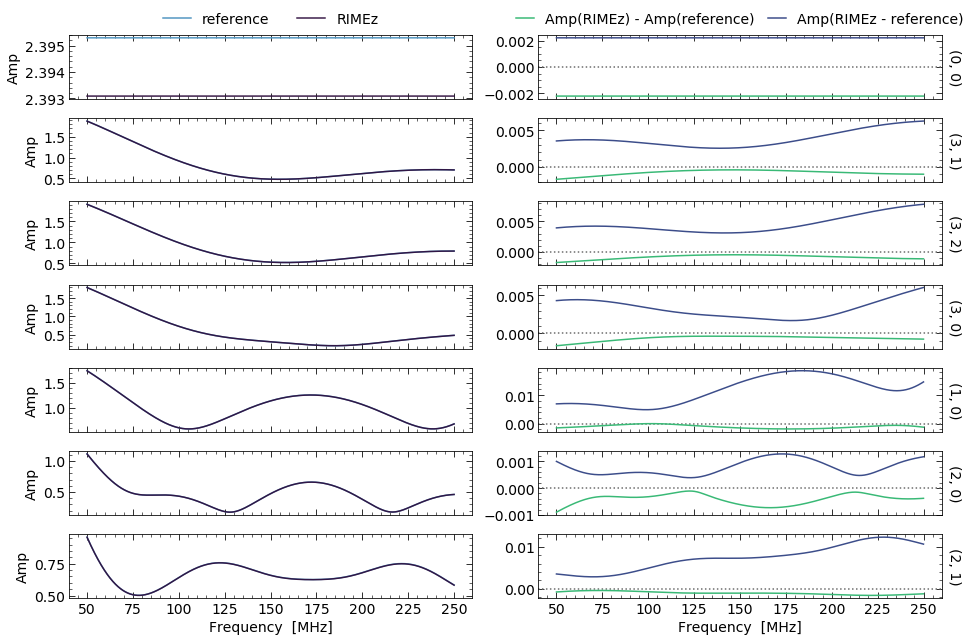

In [23]:
fig, ax = plt.subplots(len(bls_13), 2, sharex='col', figsize=(14, 9))
plot_freq_axis(uvd_ref_13['gauss'], uvd_rimez_13['gauss'], bls_13, ax=ax, component='amp')
fig.tight_layout()

Fast oscillations damped out relative to the uniform beam -- why? might be because of the weird beam in RIMEz

#### Phase

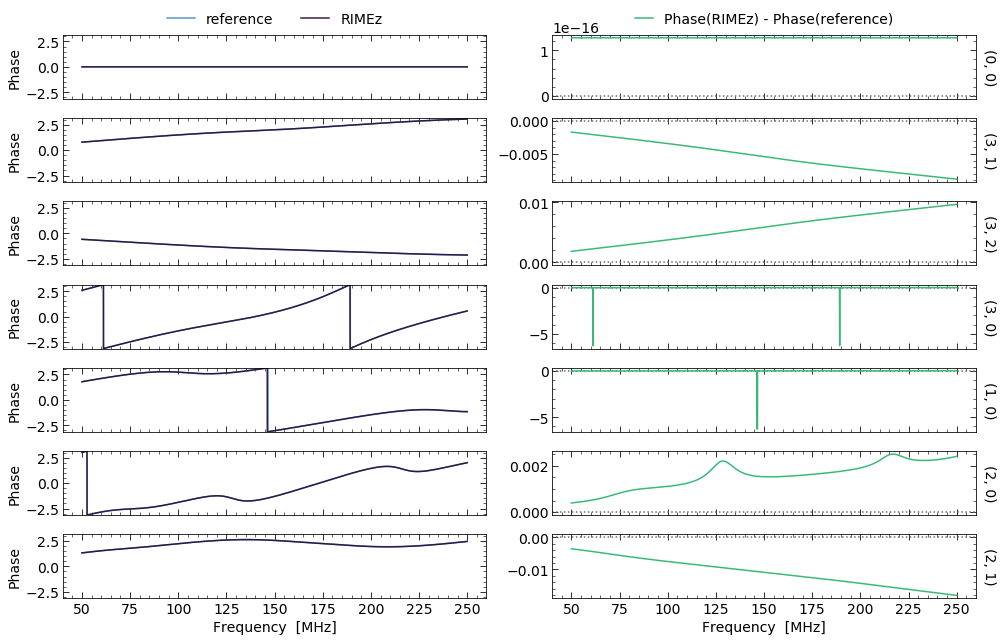

In [24]:
fig, ax = plt.subplots(len(bls_13), 2, sharex='col', figsize=(14, 9))
plot_freq_axis(uvd_ref_13['gauss'], uvd_rimez_13['gauss'], bls_13, ax=ax, component='phase')
for axis in ax[:, 0]:
    axis.set_ylim([-np.pi, np.pi])
fig.tight_layout()

### 1.3: Airy beam

*WAITING ON THE RIMEz RUN*

#### Amplitude

In [25]:
# fig, ax = plt.subplots(len(bls_13), 2, sharex='col', figsize=(14, 9))
# plot_freq_axis(uvd_ref_13['airy'], uvd_rimez_13['airy'], bls_13, ax=ax, component='amp')
# fig.tight_layout()

#### Phase

In [26]:
# fig, ax = plt.subplots(len(bls_13), 2, sharex='col', figsize=(14, 9))
# plot_freq_axis(uvd_ref_13['airy'], uvd_rimez_13['airy'], bls_13, ax=ax, component='phase')
# for axis in ax[:, 0]:
#     axis.set_ylim([-np.pi, np.pi])
# fig.tight_layout()

### 1.3: HERA beam

*WAITING ON THE RIMEz RUN*

#### Amplitude

In [27]:
# fig, ax = plt.subplots(len(bls_13), 2, sharex='col', figsize=(14, 9))
# plot_freq_axis(uvd_ref_13['hera'], uvd_rimez_13['hera'], bls_13, ax=ax, component='amp')
# fig.tight_layout()

#### Phase

In [28]:
# fig, ax = plt.subplots(len(bls_13), 2, sharex='col', figsize=(14, 9))
# plot_freq_axis(uvd_ref_13['hera'], uvd_rimez_13['hera'], bls_13, ax=ax, component='phase')
# for axis in ax[:, 0]:
#     axis.set_ylim([-np.pi, np.pi])
# fig.tight_layout()

## The effect of $\ell_\text{max}$

The maximum value of $\ell$, $\ell_\text{max}$, sets the spatial resolution of the simulation, which depends on the maximum baseline length in units of wavelength. The expression
$$\ell_\text{max} \approx \dfrac{2\pi\lvert\mathbf{u}\rvert_\text{max}}{c}$$
is a reasonable estimate for the value of $\ell_\text{max}$, although for these tests, we have added 100 to this approximation for $\ell_\text{max}$ for good measure.

#### Long time axis

In [29]:
lmax180_time_path = os.path.join(rimez_path, 'rimez_1.2_zenith_1freq_uniform_lmax180.uvh5')
lmax500_time_path = os.path.join(rimez_path, 'rimez_1.2_zenith_1freq_uniform_lmax500.uvh5')
uvd_lmax_time = {'180': UVData(), '500': UVData()}
uvd_lmax_time['180'].read(lmax180_time_path, run_check_acceptability=False)
uvd_lmax_time['500'].read(lmax500_time_path, run_check_acceptability=False)

# conjugate the RIMEz data to the pyuvsim convention (ant2 < ant1)
for beam in uvd_lmax_time.keys():
    uvd_lmax_time[beam].conjugate_bls(convention='ant2<ant1')

Telescope RIMEz is not in known_telescopes.


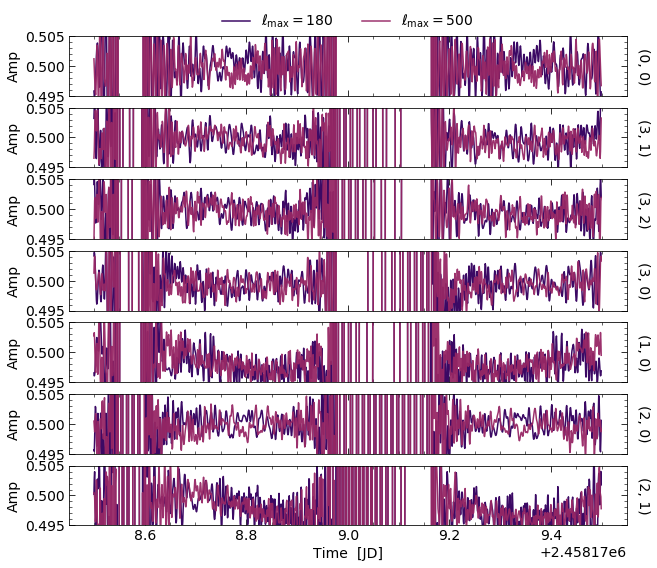

In [30]:
# overplot the amplitudes
fig, ax = plt.subplots(len(bls_12), 1, sharex='col', figsize=(10, 9))
for i, bl in enumerate(bls_12):
    ant1, ant2 = uvd_lmax_time['180'].baseline_to_antnums(bl)
    key = (ant1, ant2, 'ee')
    
    # Overplot the visibilities in the left column
    times = np.unique(uvd_lmax_time['180'].time_array)
    lmax180_data = np.abs(uvd_lmax_time['180'].get_data(key))
    lmax500_data = np.abs(uvd_lmax_time['500'].get_data(key))
    ax[i].plot(times, lmax180_data, c='#3B0964', label=r'$\ell_\mathrm{max} = 180$')
    ax[i].plot(times, lmax500_data, c='#972765', alpha=0.95, label=r'$\ell_\mathrm{max} = 500$')
    
    # Formatting things
    ax[i].set_ylim([0.495, 0.505])
    ax[i].set_ylabel('Amp', fontsize=14)          
    ax[i].text(1.03, 0.5, '({}, {})'.format(ant1, ant2), fontsize=14, ha='center',
               va='center', rotation=270, transform=ax[i].transAxes)
        
ax[-1].set_xlabel('Time  [JD]', fontsize=14)
ax[0].legend(loc='center', ncol=2, fontsize=14, frameon=False, bbox_to_anchor=(0.5, 1.25));

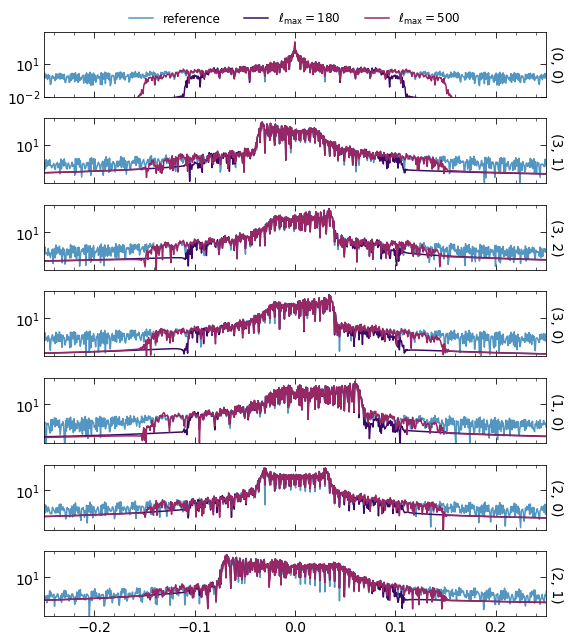

In [31]:
fig, ax = plt.subplots(len(bls_12), 1, sharex='col', figsize=(8, 9))
for i, bl in enumerate(bls_12):
    ant1, ant2 = uvd_lmax_time['180'].baseline_to_antnums(bl)
    key_ref = (ant1, ant2, 'xx')
    key_rimez = (ant1, ant2, 'ee')
    data_ref = uvd_ref_12['uniform'].get_data(key_ref)
    data_lmax180 = uvd_lmax_time['180'].get_data(key_rimez)
    data_lmax500 = uvd_lmax_time['500'].get_data(key_rimez)
    xaxis = np.fft.fftshift(np.fft.fftfreq(len(data_lmax180)))  # I do not know what units we're in here
    ft_ref = np.fft.fftshift(np.fft.fft(data_ref, axis=0))
    ft_lmax180 = np.fft.fftshift(np.fft.fft(data_lmax180, axis=0))
    ft_lmax500 = np.fft.fftshift(np.fft.fft(data_lmax500, axis=0))
    ax[i].plot(xaxis, np.abs(ft_ref), c='#5296C1', label='reference')
    ax[i].plot(xaxis, np.abs(ft_lmax180), c='#3B0964', label=r'$\ell_\mathrm{max} = 180$')
    ax[i].plot(xaxis, np.abs(ft_lmax500), c='#972765', label=r'$\ell_\mathrm{max} = 500$')
    ax[i].set_xlim(-0.25, 0.25)
    ax[i].set_yscale('log')
    ax[i].text(1.02, 0.5, '({}, {})'.format(ant1, ant2), fontsize=14, ha='center',
               va='center', rotation=270, transform=ax[i].transAxes)
ax[0].legend(loc='center', ncol=3, frameon=False, bbox_to_anchor=(0.5, 1.2), fontsize=12)
ax[0].set_ylim(ymin=0.01)
for axis in ax[1:]:
    axis.set_ylim(ymin=0.05)
fig.tight_layout()

#### Long frequency axis

In [32]:
lmax180_freq_path = os.path.join(rimez_path, 'conjugated/rimez_1.3_uniform_lmax180.uvh5')
lmax470_freq_path = os.path.join(rimez_path, 'conjugated/rimez_1.3_uniform_lmax470.uvh5')
# lmax472_freq_path = os.path.join(rimez_path, 'rimez_1.3_uniform_lmax472.uvh5')
uvd_lmax_freq = {'180': UVData(), '470': UVData()}
uvd_lmax_freq['180'].read(lmax180_freq_path, run_check_acceptability=False)
uvd_lmax_freq['470'].read(lmax470_freq_path, run_check_acceptability=False)
# uvd_lmax_freq['472'].read(lmax472_freq_path, run_check_acceptability=False)

# conjugate the RIMEz data to the pyuvsim convention (ant2 < ant1)
for beam in uvd_lmax_freq.keys():
    uvd_lmax_freq[beam].conjugate_bls(convention='ant2<ant1')

Telescope RIMEz is not in known_telescopes.


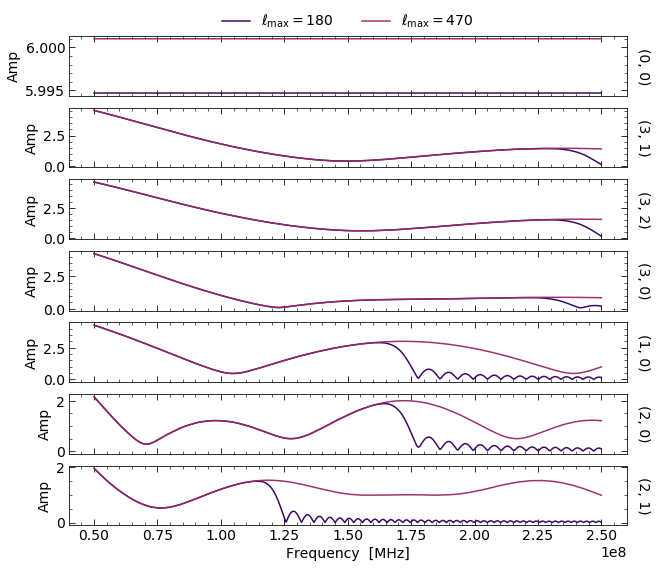

In [33]:
# overplot the amplitudes
fig, ax = plt.subplots(len(bls_13), 1, sharex='col', figsize=(10, 9))
for i, bl in enumerate(bls_13):
    ant1, ant2 = uvd_lmax_freq['180'].baseline_to_antnums(bl)
    key = (ant1, ant2, 'ee')

    # Overplot the visibilities in the left column
    freqs = np.unique(uvd_lmax_freq['180'].freq_array)
    lmax180_data = np.abs(uvd_lmax_freq['180'].get_data(key))
    lmax470_data = np.abs(uvd_lmax_freq['470'].get_data(key))
    # lmax472_data = np.abs(uvd_lmax_freq['472'].get_data(key))
    ax[i].plot(freqs, lmax180_data[0], c='#3B0964', label=r'$\ell_\mathrm{max} = 180$')
    ax[i].plot(freqs, lmax470_data[0], c='#972765', alpha=0.95, label=r'$\ell_\mathrm{max} = 470$')
    # ax[i].plot(freqs, lmax472_data[0], c='#972765', alpha=0.95, label=r'$\ell_\mathrm{max} = 472$')
    
    # Formatting things
    ax[i].set_ylabel('Amp', fontsize=14)          
    ax[i].text(1.03, 0.5, '({}, {})'.format(ant1, ant2), fontsize=14, ha='center',
               va='center', rotation=270, transform=ax[i].transAxes)
        
ax[-1].set_xlabel('Frequency  [MHz]', fontsize=14)
ax[0].legend(loc='center', ncol=2, fontsize=14, frameon=False, bbox_to_anchor=(0.5, 1.25));